# ML-Based Marketing

Руководитель: [Лукьянченко Пётр Павлович](https://www.hse.ru/staff/lukianchenko)

Студенты: [Гончаров Фёдор Михайлович](http://t.me/fmgoncharov), [Писцов Георгий Константинович](http://t.me/GoshaNice)

Материалы:
- [КТ1](https://drive.google.com/file/d/1X9sN0MSib5yEGM-PElc6Y33UsGcLC2Nz/view?usp=share_link)
- [CausalML](https://github.com/uber/causalml)
- [EconlML](https://github.com/py-why/EconML)

## Первичная подготовка данных

Импортируем все необходимые библиотеки

In [1]:
from IPython.display import display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import csv

Загружаем датасеты за 3 месяца

In [2]:
jan2feb = pd.read_csv('jan2feb.csv', sep=';', parse_dates=['Дата'], dayfirst=True).iloc[::-1]
feb2mar = pd.read_csv('feb2mar.csv', sep=';', parse_dates=['Дата'], dayfirst=True).iloc[::-1]
mar2apr = pd.read_csv('mar2apr.csv', sep=';', parse_dates=['Дата'], dayfirst=True).iloc[::-1]

Объединяем три месяца в один датасет, выставляем даты транзакций как индексы, убираем колонку с уникальными номерами заказов

In [3]:
df = pd.concat([jan2feb, feb2mar, mar2apr], ignore_index=True, verify_integrity=True)
df.rename(columns={"Дата": "Date", "Профиль участника": "UID", "Вид операции": "OperationType", "Сумма": "Price", "Сумма списанных монет": "SpentCoins", "Сумма начисленных монет": "GainedCoins", "Ресторан": "Point", "Агент продаж": "Agent", "Статус": "Status"}, inplace=True)
df.set_index('Date', inplace=True)
df.drop(columns=['Номер'], inplace=True)
df.head()

,UID,OperationType,Price,SpentCoins,GainedCoins,Point,Agent,Status
Date,,,,,,,,
2023-01-15 00:06:45,37704f27-3e29-11eb-80c2-00155d01af05,Покупка,127.0,37.0,2.54,Р АЭРОПОРТ,Касса,Бронзовый ключ
2023-01-15 00:12:34,0ca8729c-f364-11ea-80e4-f403435823a3,Покупка,105.0,NaN,2.10,Р АЭРОПОРТ,Касса,Бронзовый ключ
2023-01-15 00:22:00,b152cb7e-de6e-11ec-80dc-00155dd23e20,Покупка,551.0,9.0,16.53,Р АЭРОПОРТ,Касса,Серебряный ключ
2023-01-15 00:34:51,0ca8729c-f364-11ea-80e4-f403435823a3,Покупка,113.0,NaN,2.26,Р АЭРОПОРТ,Касса,Бронзовый ключ
2023-01-15 00:36:00,b152cb7e-de6e-11ec-80dc-00155dd23e20,Покупка,280.0,NaN,8.40,Р АЭРОПОРТ,Касса,Серебряный ключ


In [4]:
day_of_week_labels = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
months_labels = ['Январь', 'Февраль', 'Май', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
assert(len(day_of_week_labels) == 7 and len(months_labels) == 12)

start_dt, end_dt = df.iloc[0].name, df.iloc[-1].name
print(f'Датасет начинается {start_dt.day} {months_labels[start_dt.month-1][:-1]}я и заканчивается {end_dt.day} {months_labels[end_dt.month-1][:-1]}я включительно')

Датасет начинается 15 Января и заканчивается 14 Апреля включительно


Проверяем размер данных

In [5]:
m, n = df.shape
numerical = ['Price', 'SpentCoins', 'GainedCoins', 'ActualPrice']
categorical = ['OperationType', 'Point', 'Agent', 'Status']
print(f"В датасете {m} строк и {n} столбцов")
print(f"Из них {len(numerical)} численных и {len(categorical)} категориальных")
assert(len(numerical) + len(categorical) == n)

В датасете 2267437 строк и 8 столбцов
Из них 4 численных и 4 категориальных


Заполняем пропуски по потраченным и начисленным монетам. Делаем колонку по процент накопления монет по статусу

In [6]:
cols_with_nans = []
for col in df:
    if df[col].isna().sum() > 0:
        cols_with_nans.append(col)
        df[col].fillna(0, inplace=True)
print("Найдены пропуски в колонках", *cols_with_nans)
print("Пропуски заполнены нулями")

df['Discount'] = df['Status'].replace({"Бронзовый ключ": 0.02, "Серебряный ключ": 0.03, "Золотой ключ": 0.05, "Платиновый ключ": 0.07, "Сотрудник": 0.15})

Найдены пропуски в колонках SpentCoins GainedCoins
Пропуски заполнены нулями


In [7]:
assert(len(df.groupby('UID')['Status'].nunique().unique()) > 1)
print("Статусы соответсвуют дню совершения транзакции")

Статусы соответсвуют дню совершения транзакции


## Анализ данных. Построение графиков

Исследуем корреляционную матрицу численных переменных датасета. Колонки Price и GainedCoins ожидаемо имеют высокую корелляцию

/var/folders/mr/qh1d74xx1879g41tnvr1g9j00000gn/T/ipykernel_4099/2700590646.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


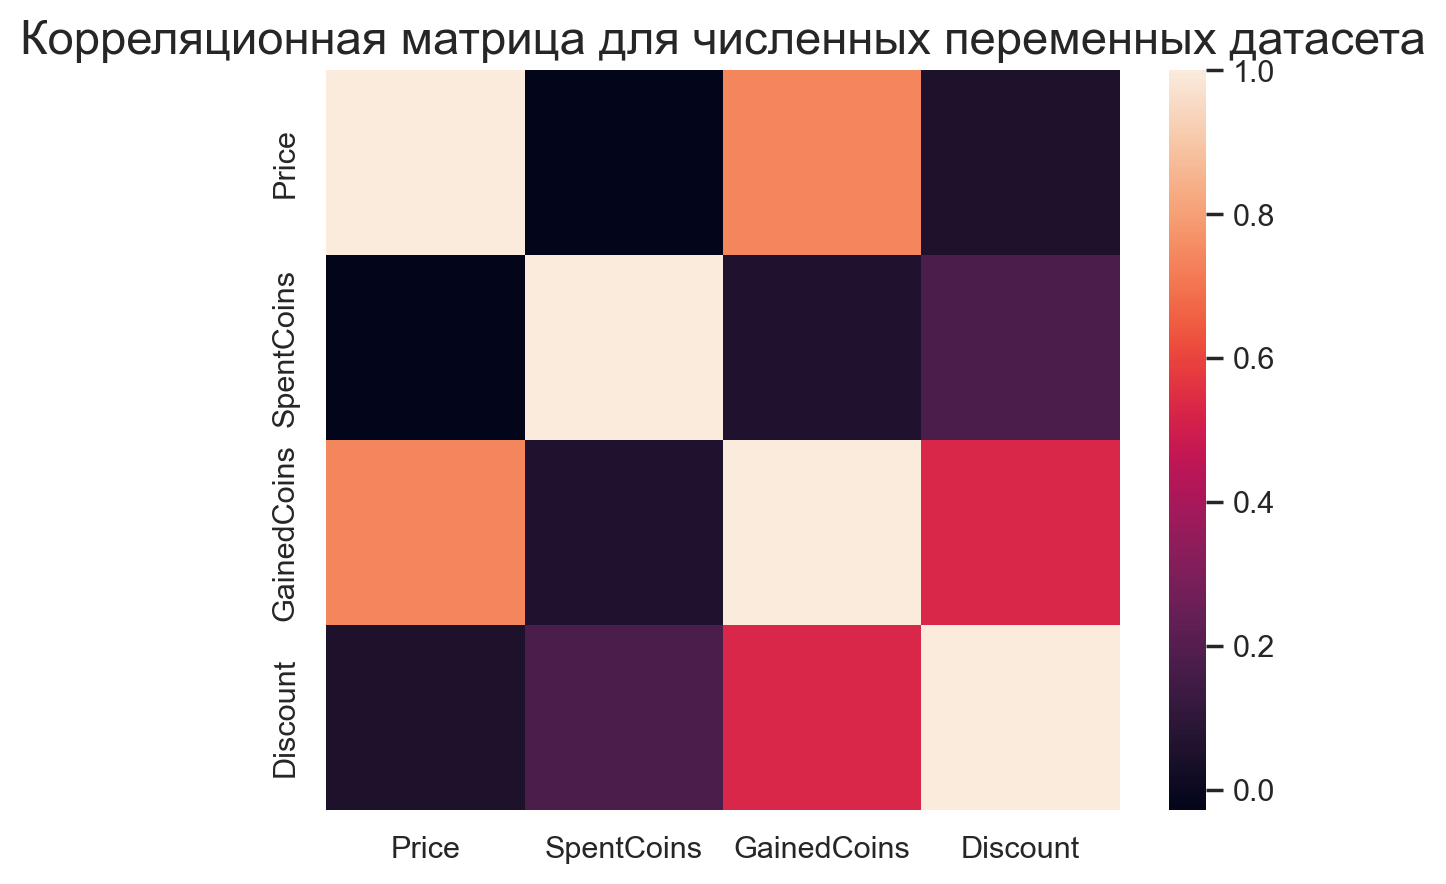

In [8]:
corr = df.corr()
sns.set_theme()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
plt.title('Корреляционная матрица для численных переменных датасета', fontsize=17)
plt.show()

Добавляем технические переменные о датах совершения транзакции

In [9]:
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['Hour'] = df.index.hour
df['DayOfYear'] = df.index.dayofyear

Исследуем остальные данные о транзакциях

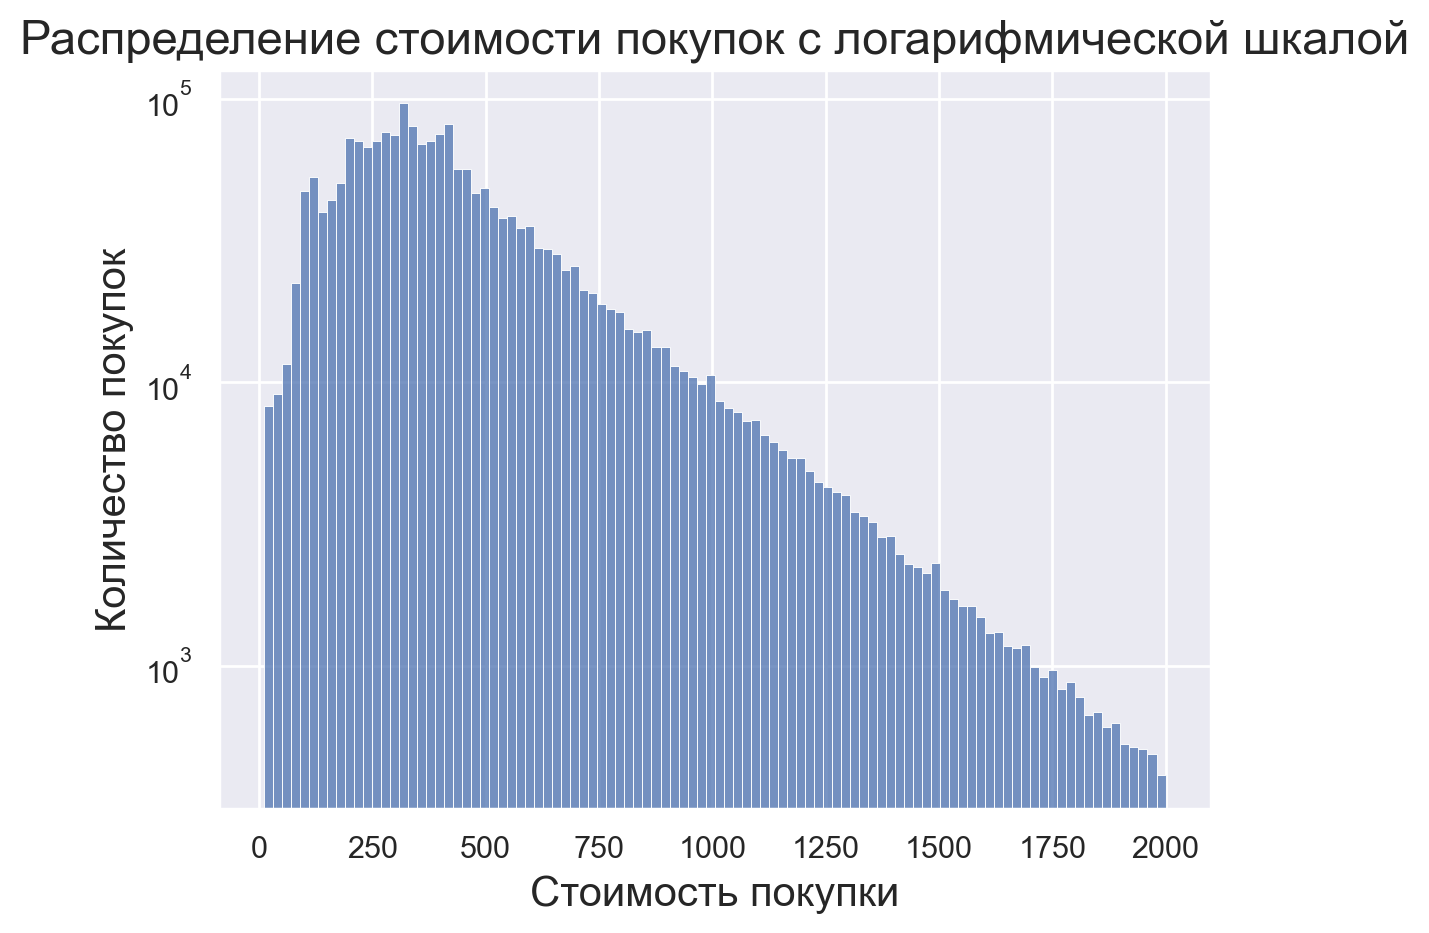

In [10]:
sns.histplot(df[(df['Price'] > 10) & (df['Price'] < 2000)]['Price'], bins=100)
plt.title('Распределение стоимости покупок с логарифмической шкалой', fontsize=17)
plt.xlabel('Стоимость покупки', fontsize=15)
plt.ylabel('Количество покупок', fontsize=15)
plt.yscale('log')
plt.show()

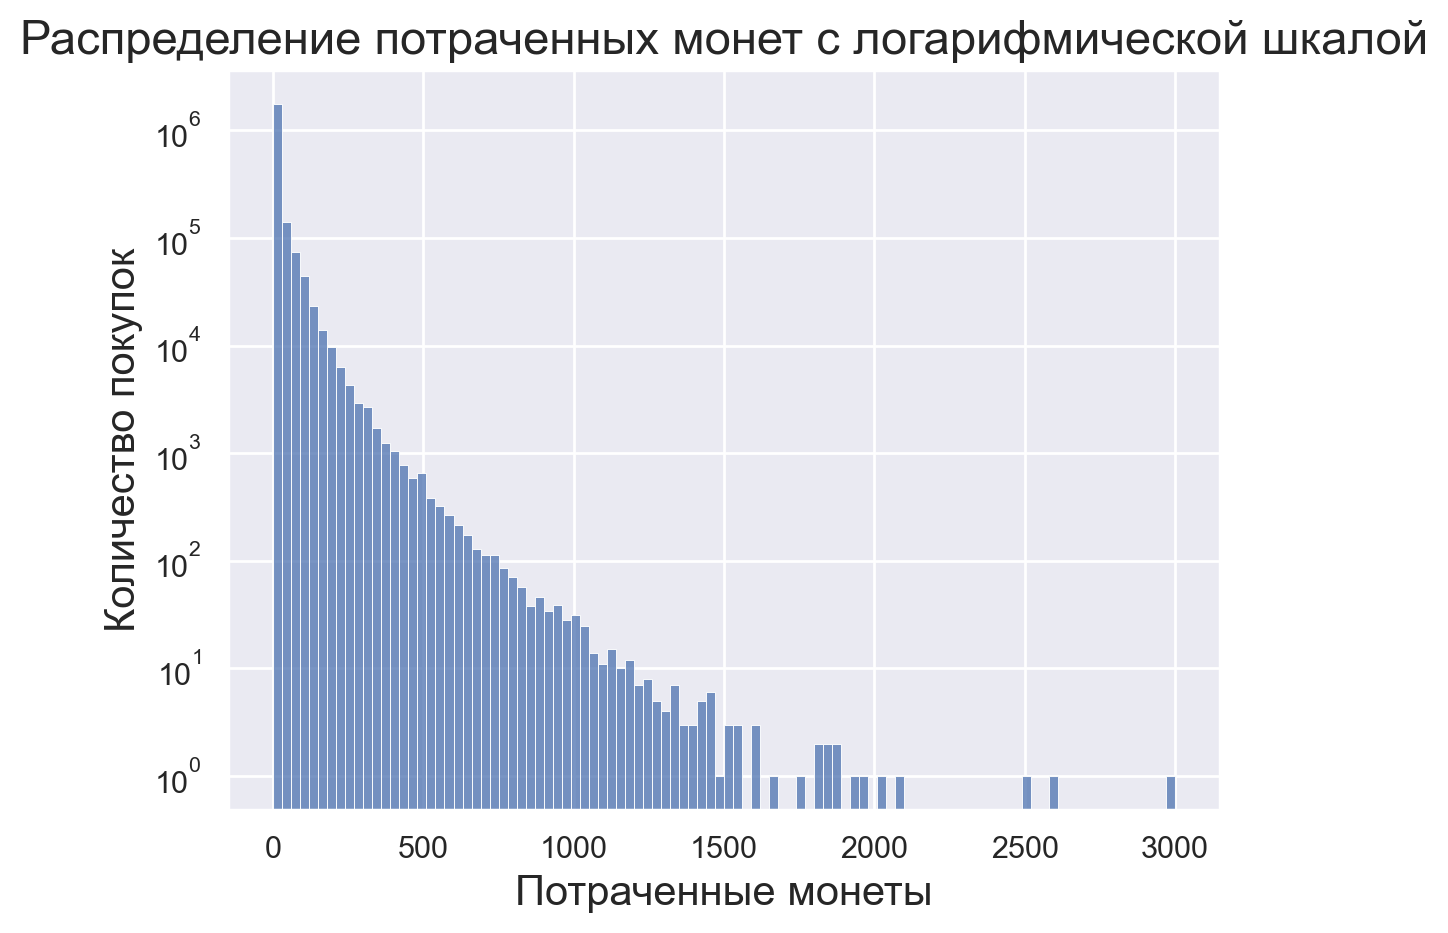

In [11]:
sns.histplot(df[(df['Price'] > 10) & (df['Price'] < 2000) & (df['SpentCoins'] >= 0)]['SpentCoins'], bins=100)
plt.title('Распределение потраченных монет с логарифмической шкалой', fontsize=17)
plt.xlabel('Потраченные монеты', fontsize=15)
plt.ylabel('Количество покупок', fontsize=15)
plt.yscale('log')
plt.show()

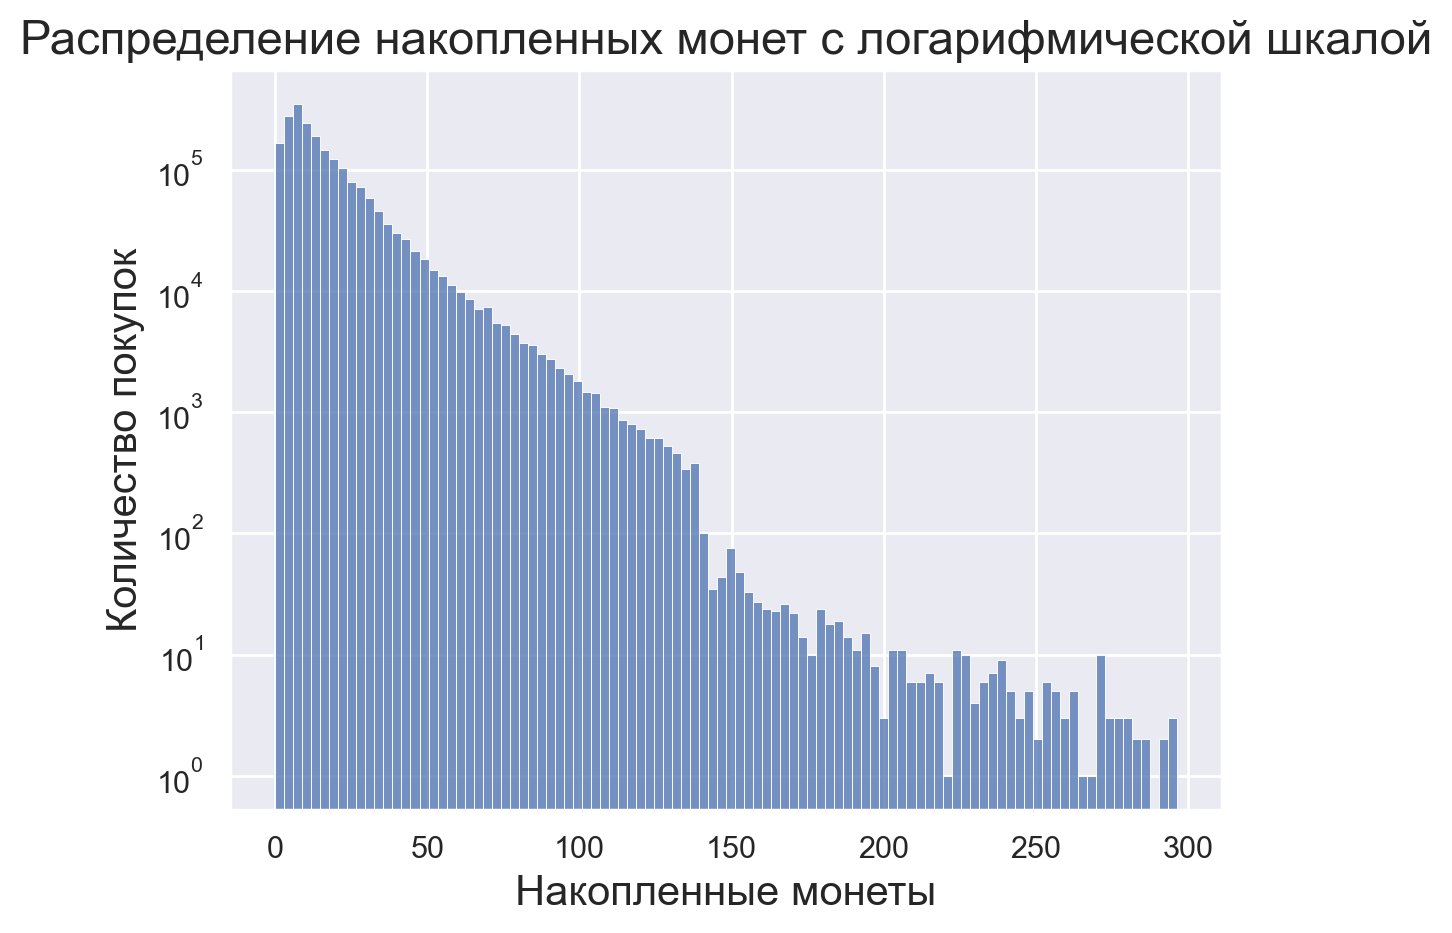

In [12]:
sns.histplot(df[(df['Price'] > 10) & (df['Price'] < 2000) & (df['GainedCoins'] >= 0)]['GainedCoins'], bins=100)
plt.title('Распределение накопленных монет с логарифмической шкалой', fontsize=17)
plt.xlabel('Накопленные монеты', fontsize=15)
plt.ylabel('Количество покупок', fontsize=15)
plt.yscale('log')
plt.show()

## Поправить график и посмотреть не только по транзакциям, но и по клиентам

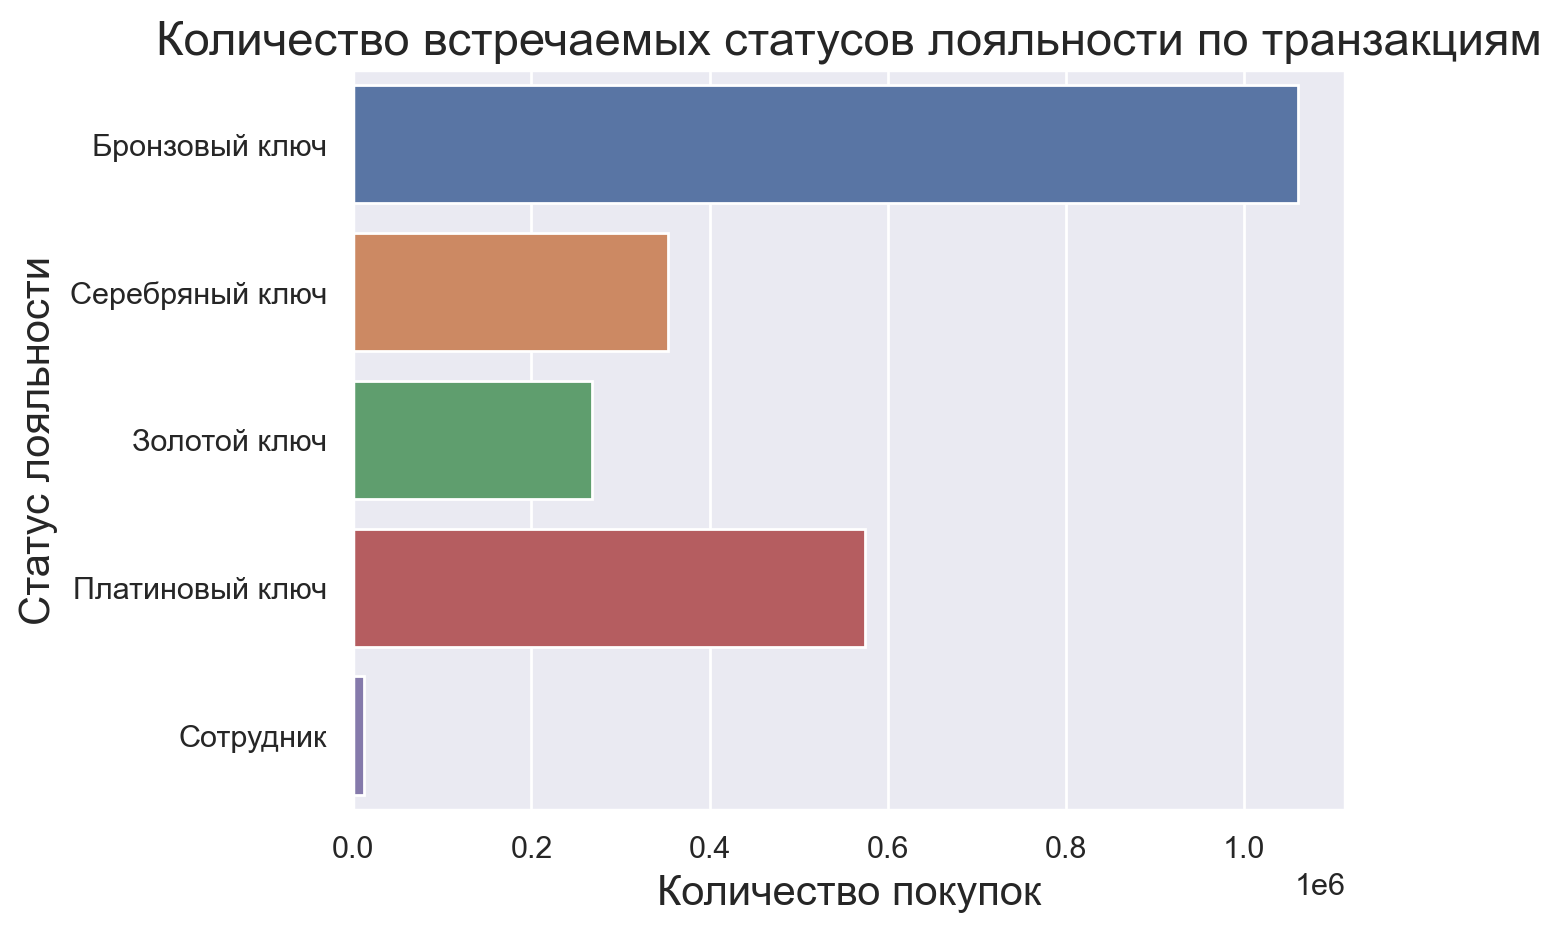

In [13]:
sns.countplot(data=df, y='Status', order=['Бронзовый ключ', 'Серебряный ключ', 'Золотой ключ', 
       'Платиновый ключ', 'Сотрудник'])
plt.title('Количество встречаемых статусов лояльности по транзакциям', fontsize=17)
plt.xlabel('Количество покупок', fontsize=15)
plt.ylabel('Статус лояльности', fontsize=15)
plt.show()

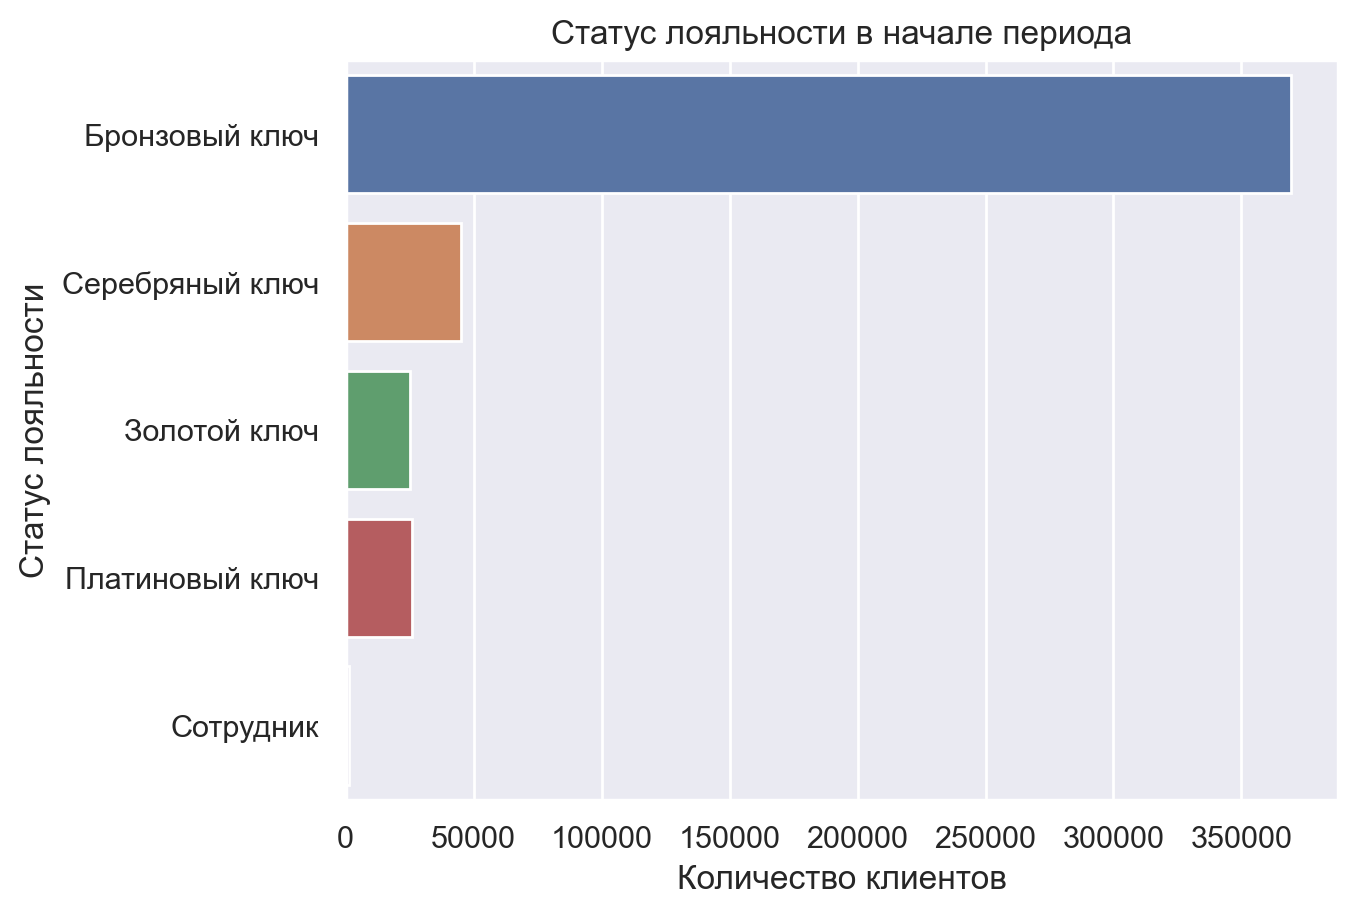

In [14]:
sns.countplot(order=['Бронзовый ключ', 'Серебряный ключ', 'Золотой ключ', 
       'Платиновый ключ', 'Сотрудник'], y='Status', data=df.groupby('UID').Status.first().to_frame())
plt.title('Статус лояльности в начале периода')
plt.xlabel("Количество клиентов")
plt.ylabel("Статус лояльности")
plt.show()

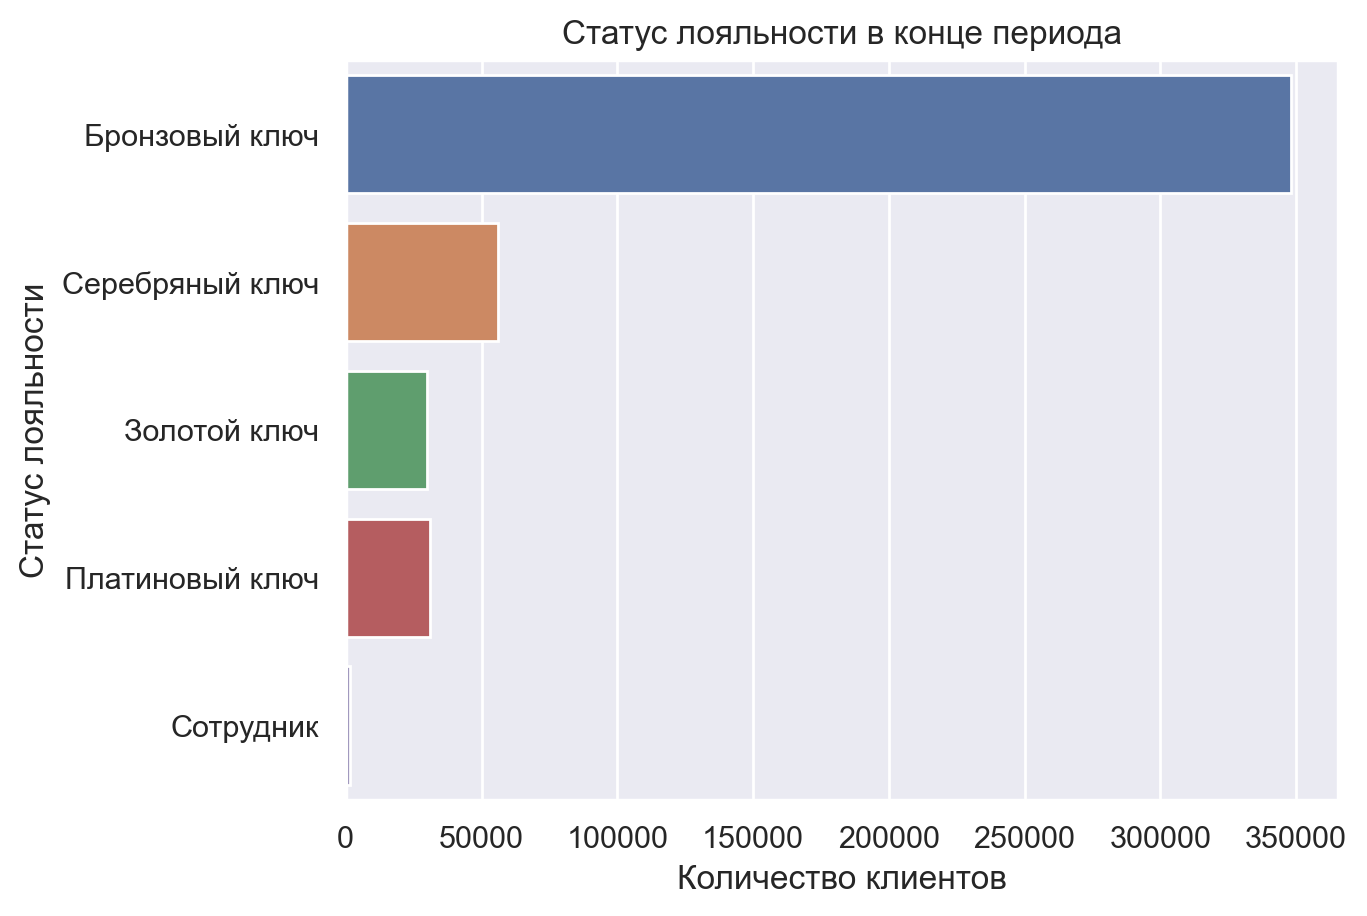

In [15]:
sns.countplot(order=['Бронзовый ключ', 'Серебряный ключ', 'Золотой ключ', 
       'Платиновый ключ', 'Сотрудник'], y='Status', data=df.groupby('UID').Status.last().to_frame())
plt.title('Статус лояльности в конце периода')
plt.xlabel("Количество клиентов")
plt.ylabel("Статус лояльности")
plt.show()

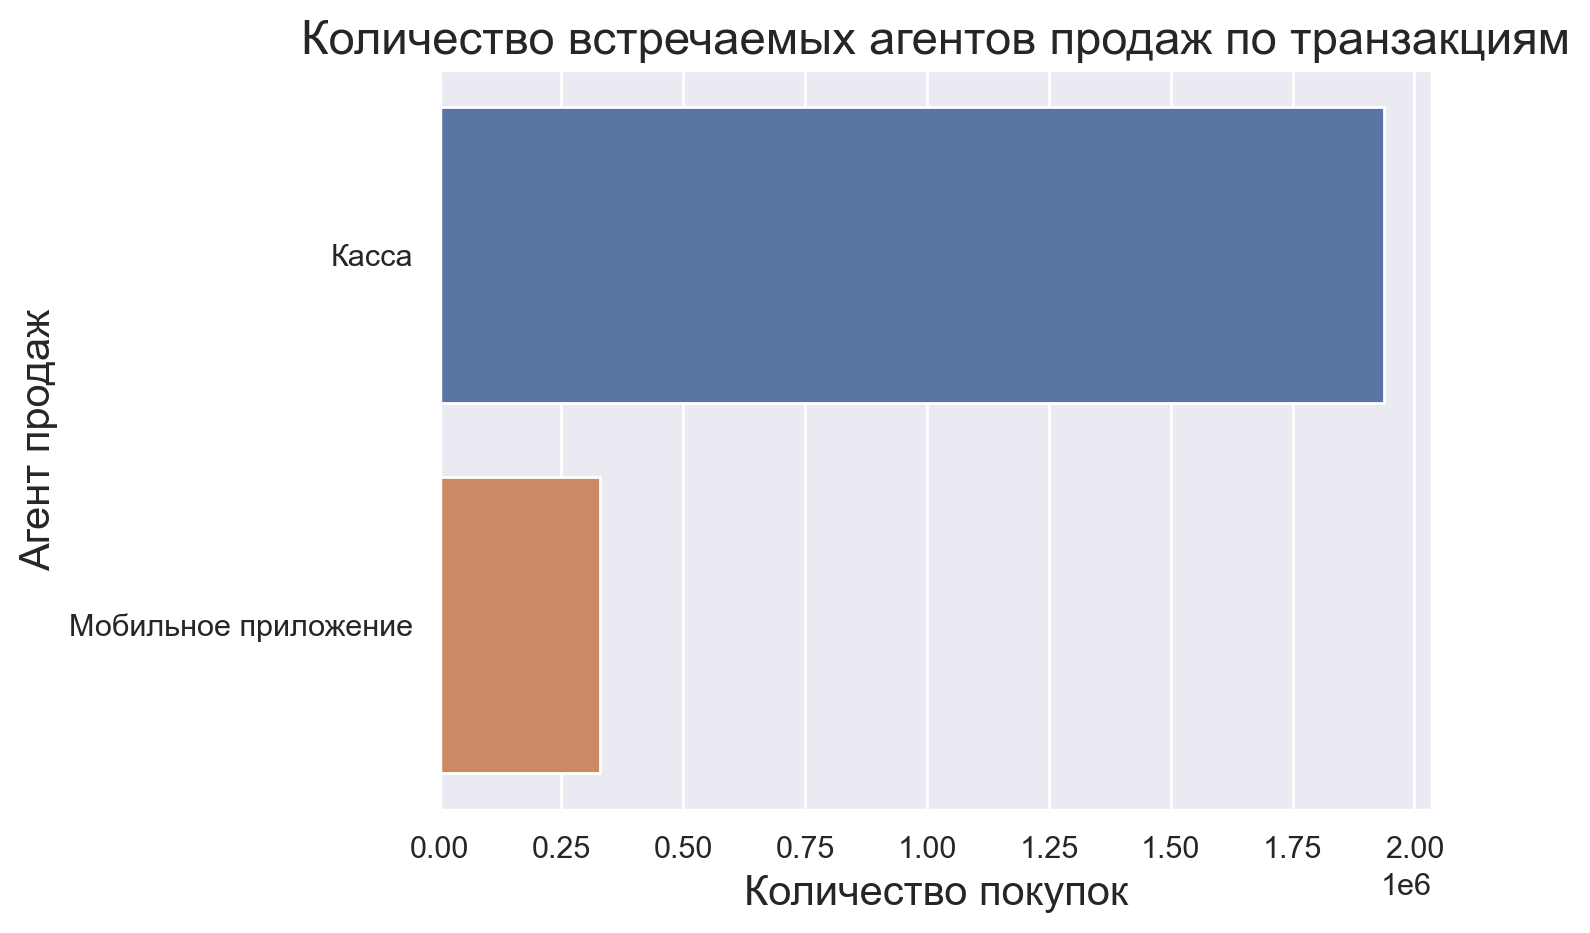

In [16]:
sns.countplot(data=df, y='Agent')
plt.title('Количество встречаемых агентов продаж по транзакциям', fontsize=17)
plt.xlabel('Количество покупок', fontsize=15)
plt.ylabel('Агент продаж', fontsize=15)
plt.show()

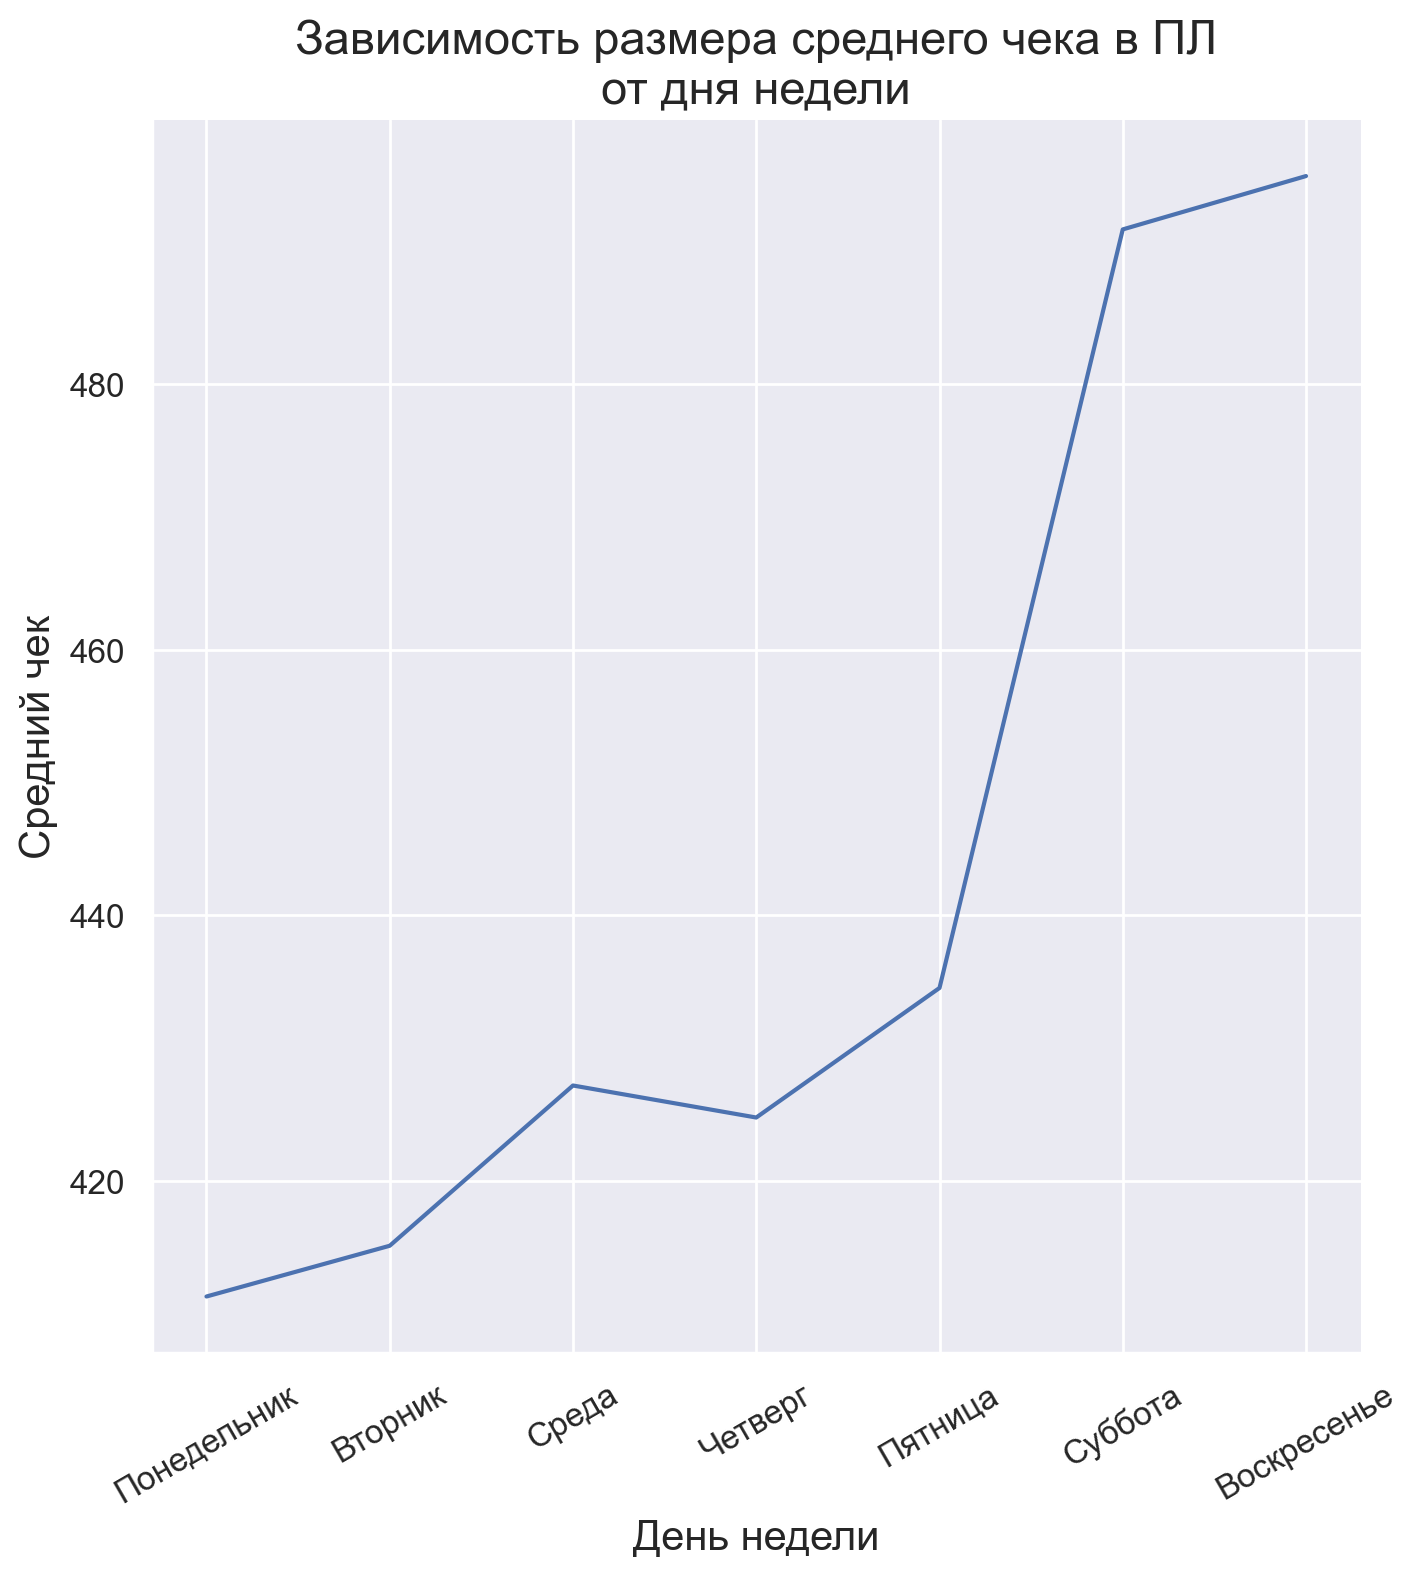

In [17]:
sns.relplot(df.groupby('DayOfWeek').Price.mean(), kind='line', height=7)
plt.title('Зависимость размера среднего чека в ПЛ\nот дня недели', fontsize=17)
plt.xlabel('День недели', fontsize=15)
plt.ylabel('Средний чек', fontsize=15)
plt.xticks(np.arange(7),
           labels=day_of_week_labels,
           fontsize=12,
           rotation=30)
plt.yticks(fontsize=12)
plt.show()

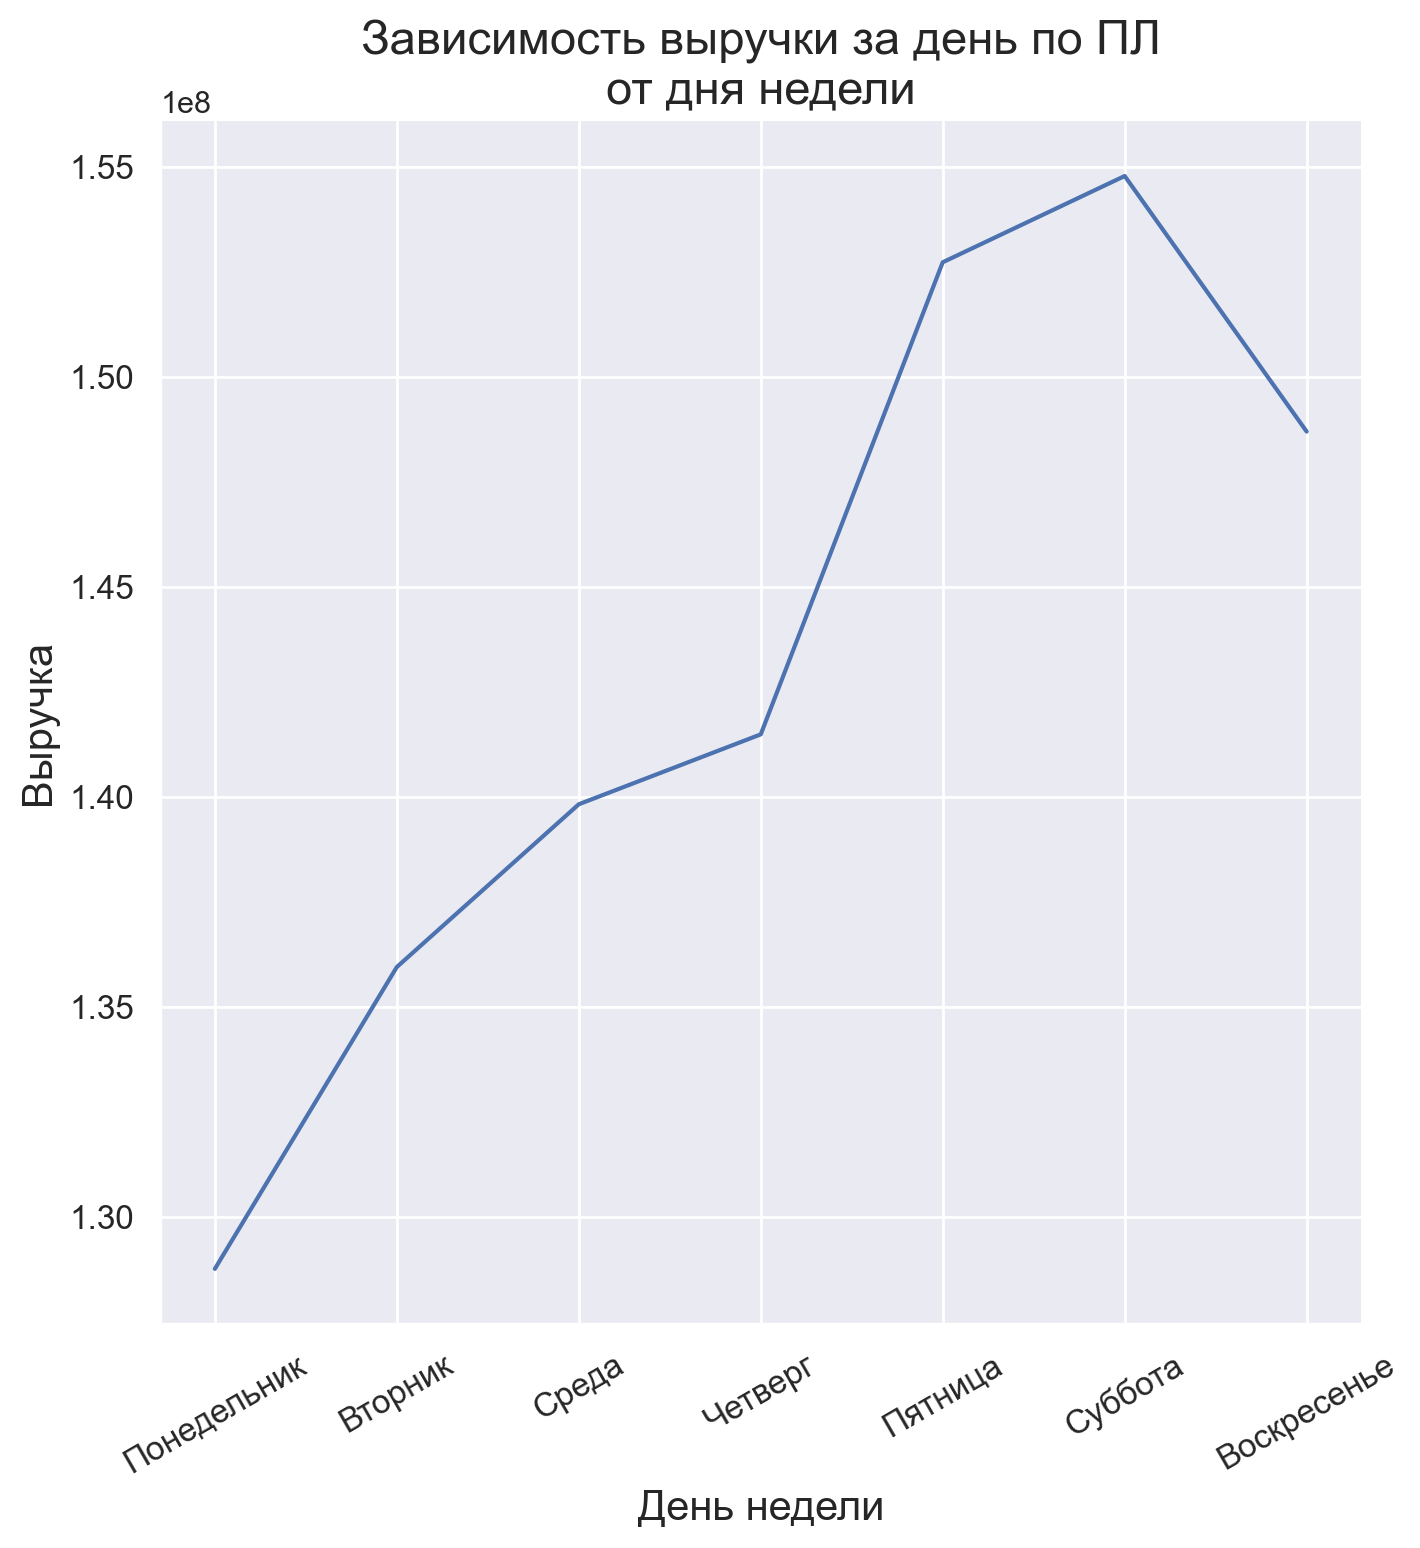

In [18]:
sns.relplot(df.groupby('DayOfWeek').Price.sum(), kind='line', height=7)
plt.title('Зависимость выручки за день по ПЛ\nот дня недели', fontsize=17)
plt.xlabel('День недели', fontsize=15)
plt.ylabel('Выручка', fontsize=15)
plt.xticks(np.arange(7),
           labels=day_of_week_labels,
           fontsize=12,
           rotation=30)
plt.yticks(fontsize=12)
plt.show()

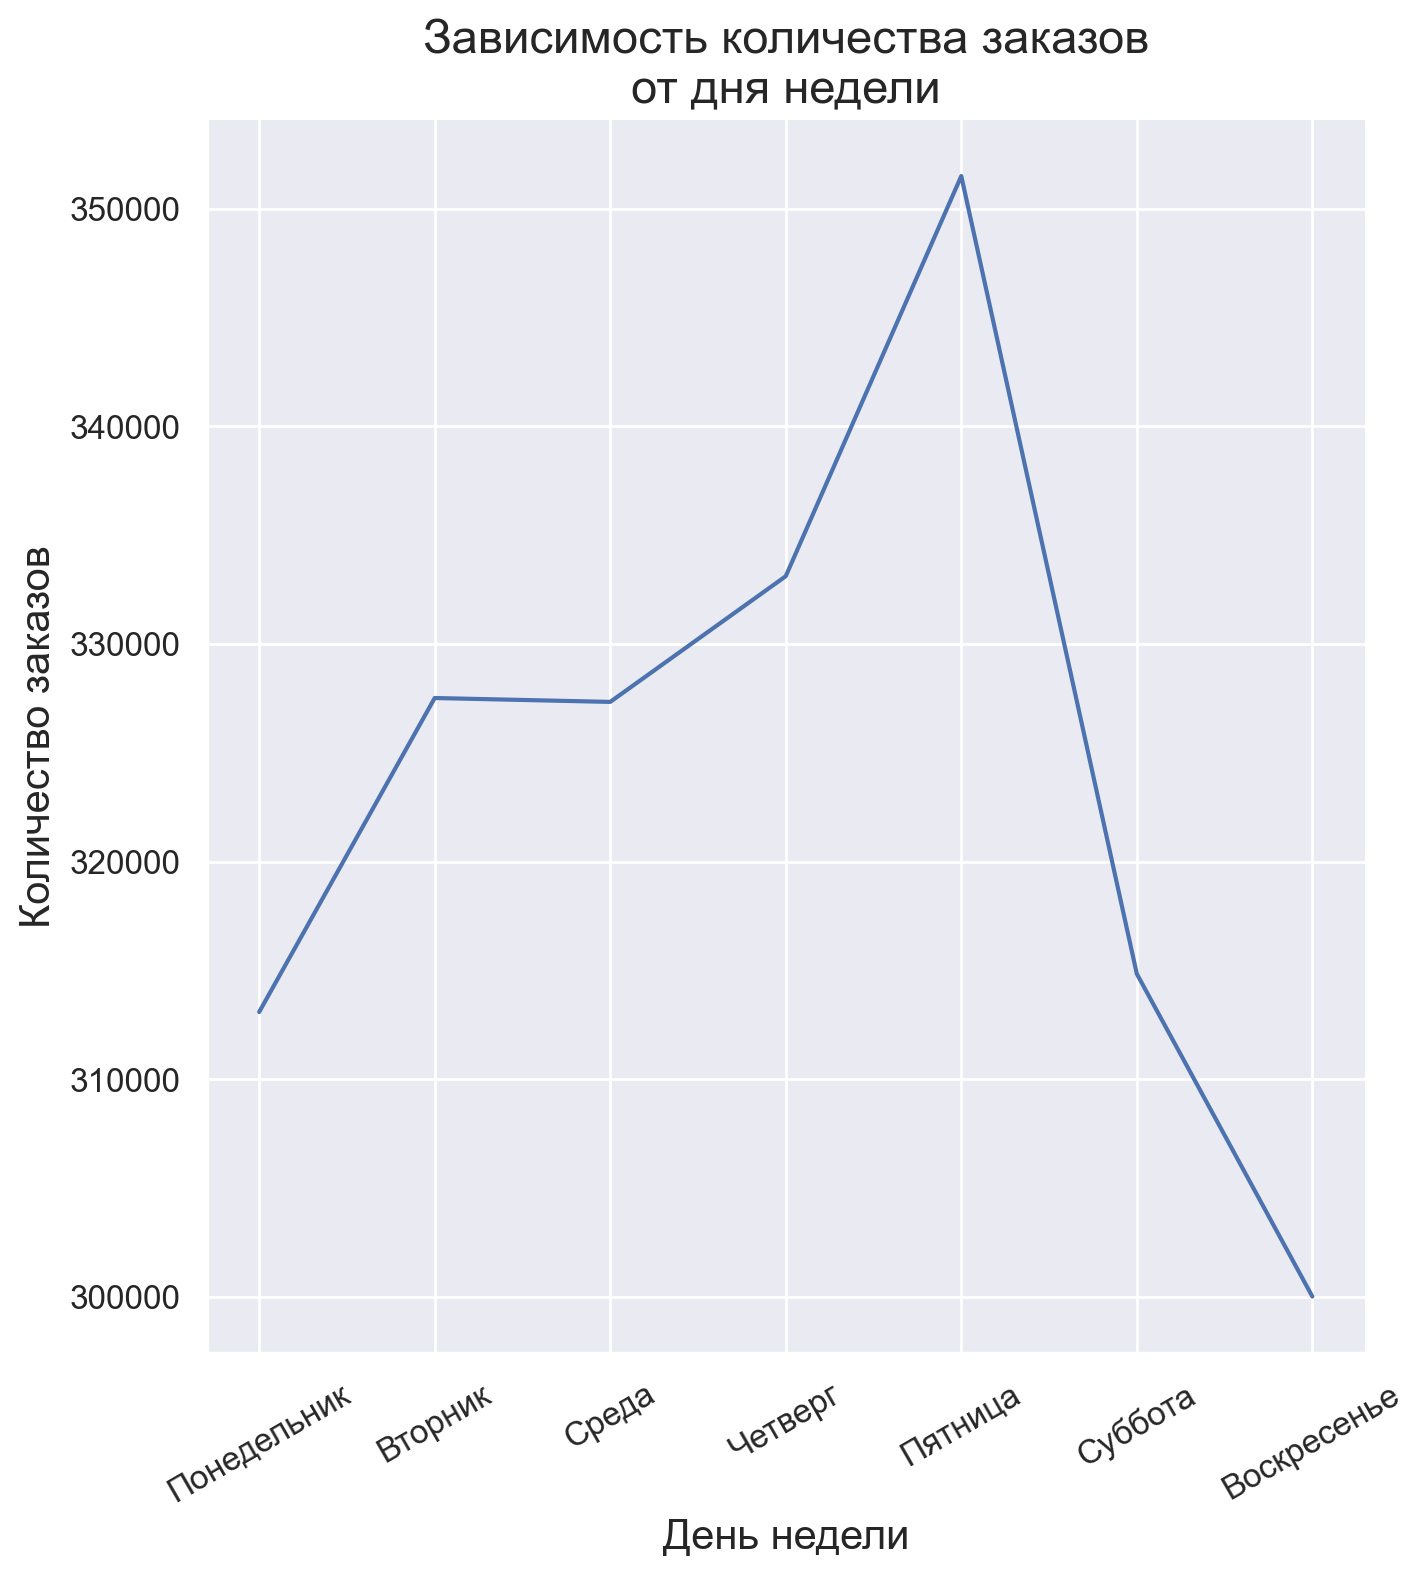

In [19]:
sns.relplot(df.groupby('DayOfWeek').UID.count(), kind='line', height=7)
plt.title('Зависимость количества заказов\nот дня недели', fontsize=17)
plt.xlabel('День недели', fontsize=15)
plt.ylabel('Количество заказов', fontsize=15)
plt.xticks(np.arange(7),
           labels=day_of_week_labels,
           fontsize=12,
           rotation=30)
plt.yticks(fontsize=12)
plt.show()

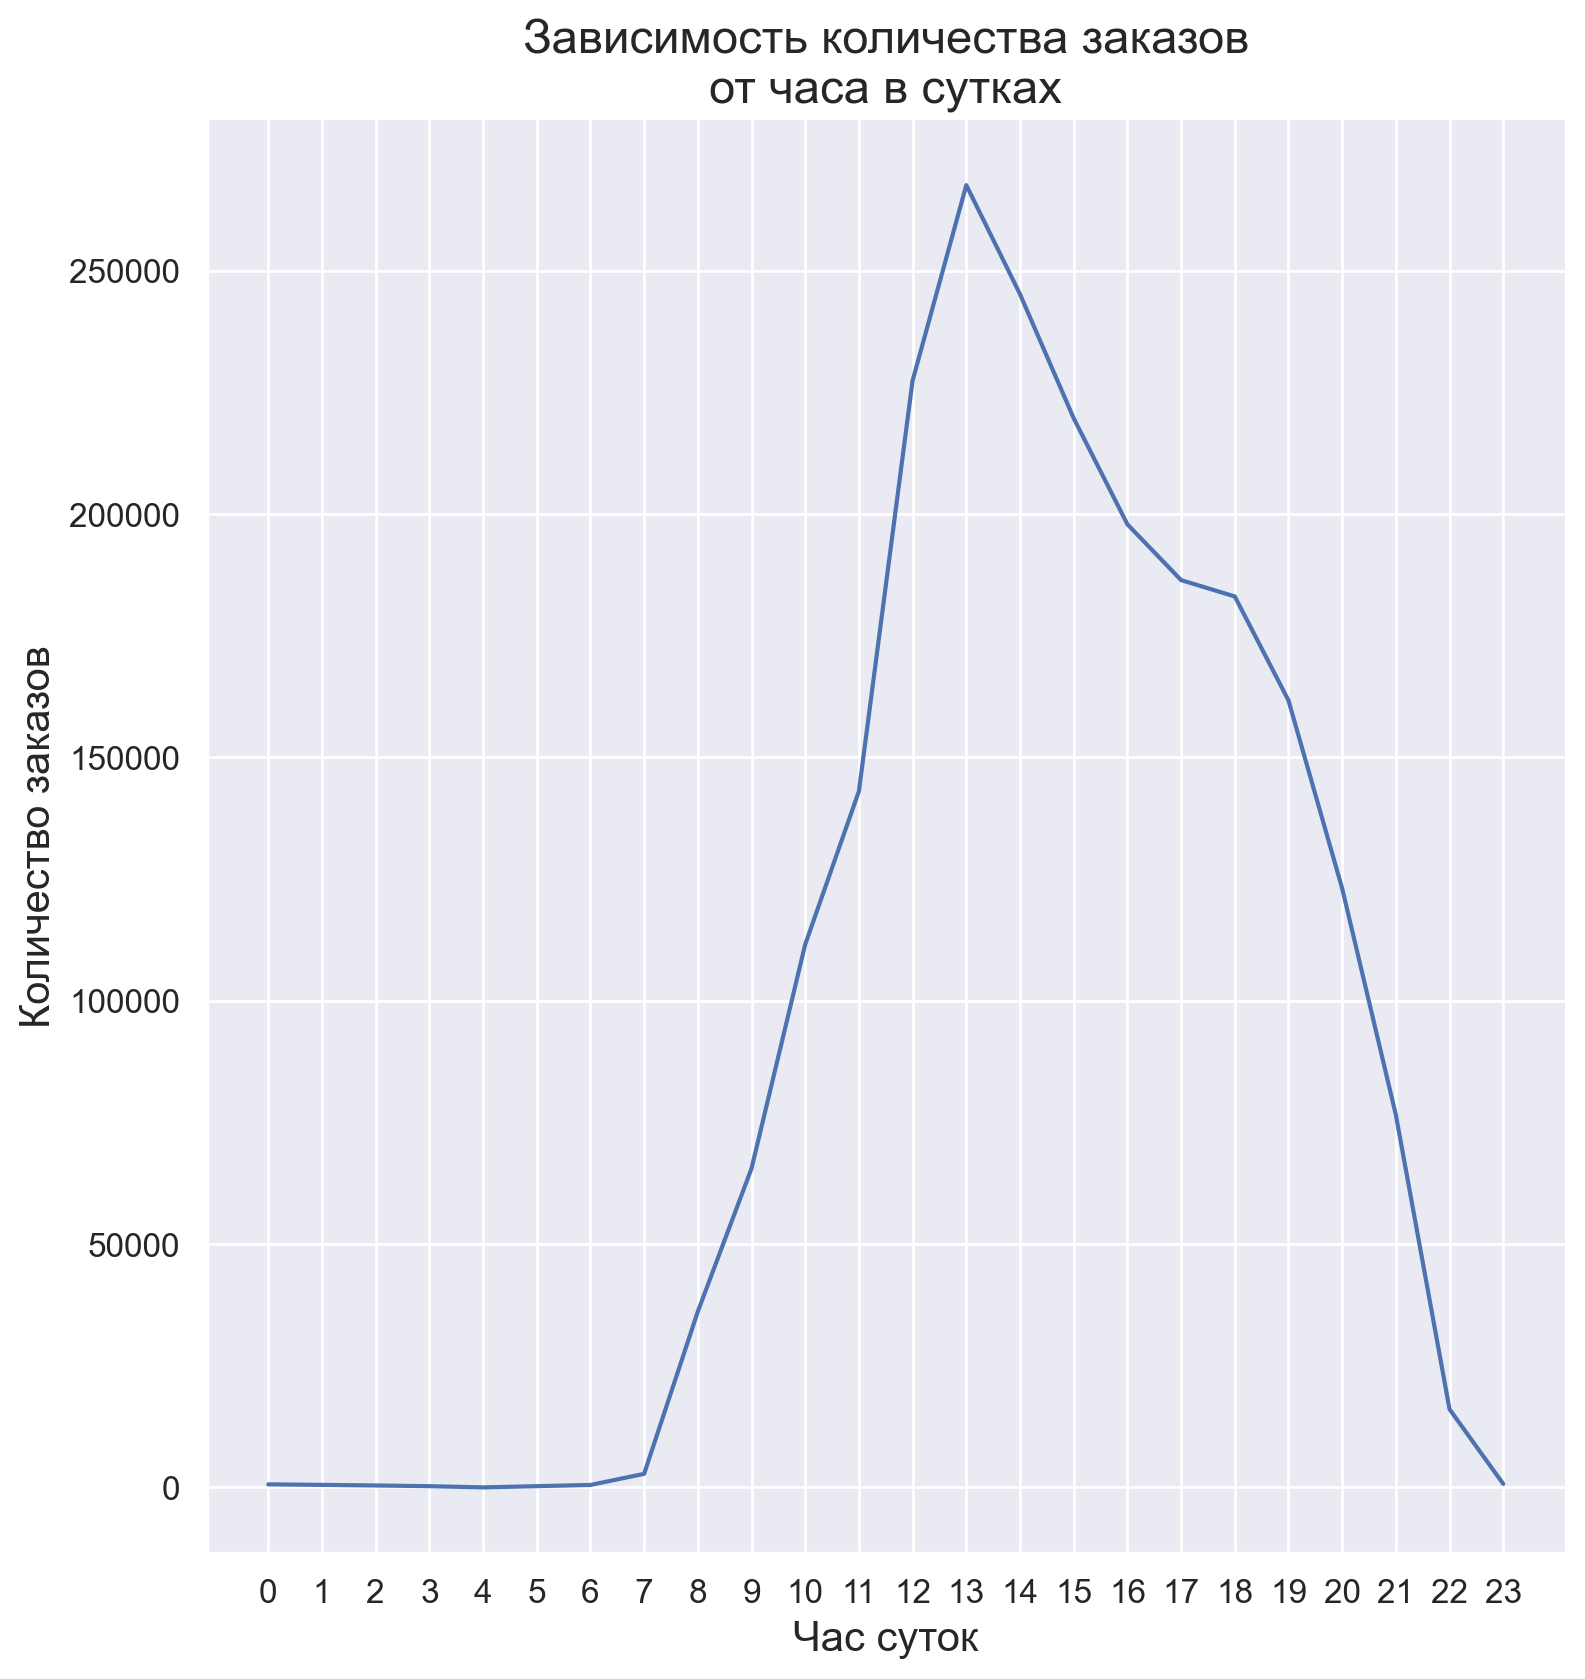

In [20]:
sns.relplot(df.groupby('Hour').UID.count(), kind='line', height=8)
plt.title('Зависимость количества заказов\nот часа в сутках', fontsize=17)
plt.xlabel('Час суток', fontsize=15)
plt.ylabel('Количество заказов', fontsize=15)
plt.xticks(np.arange(24), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

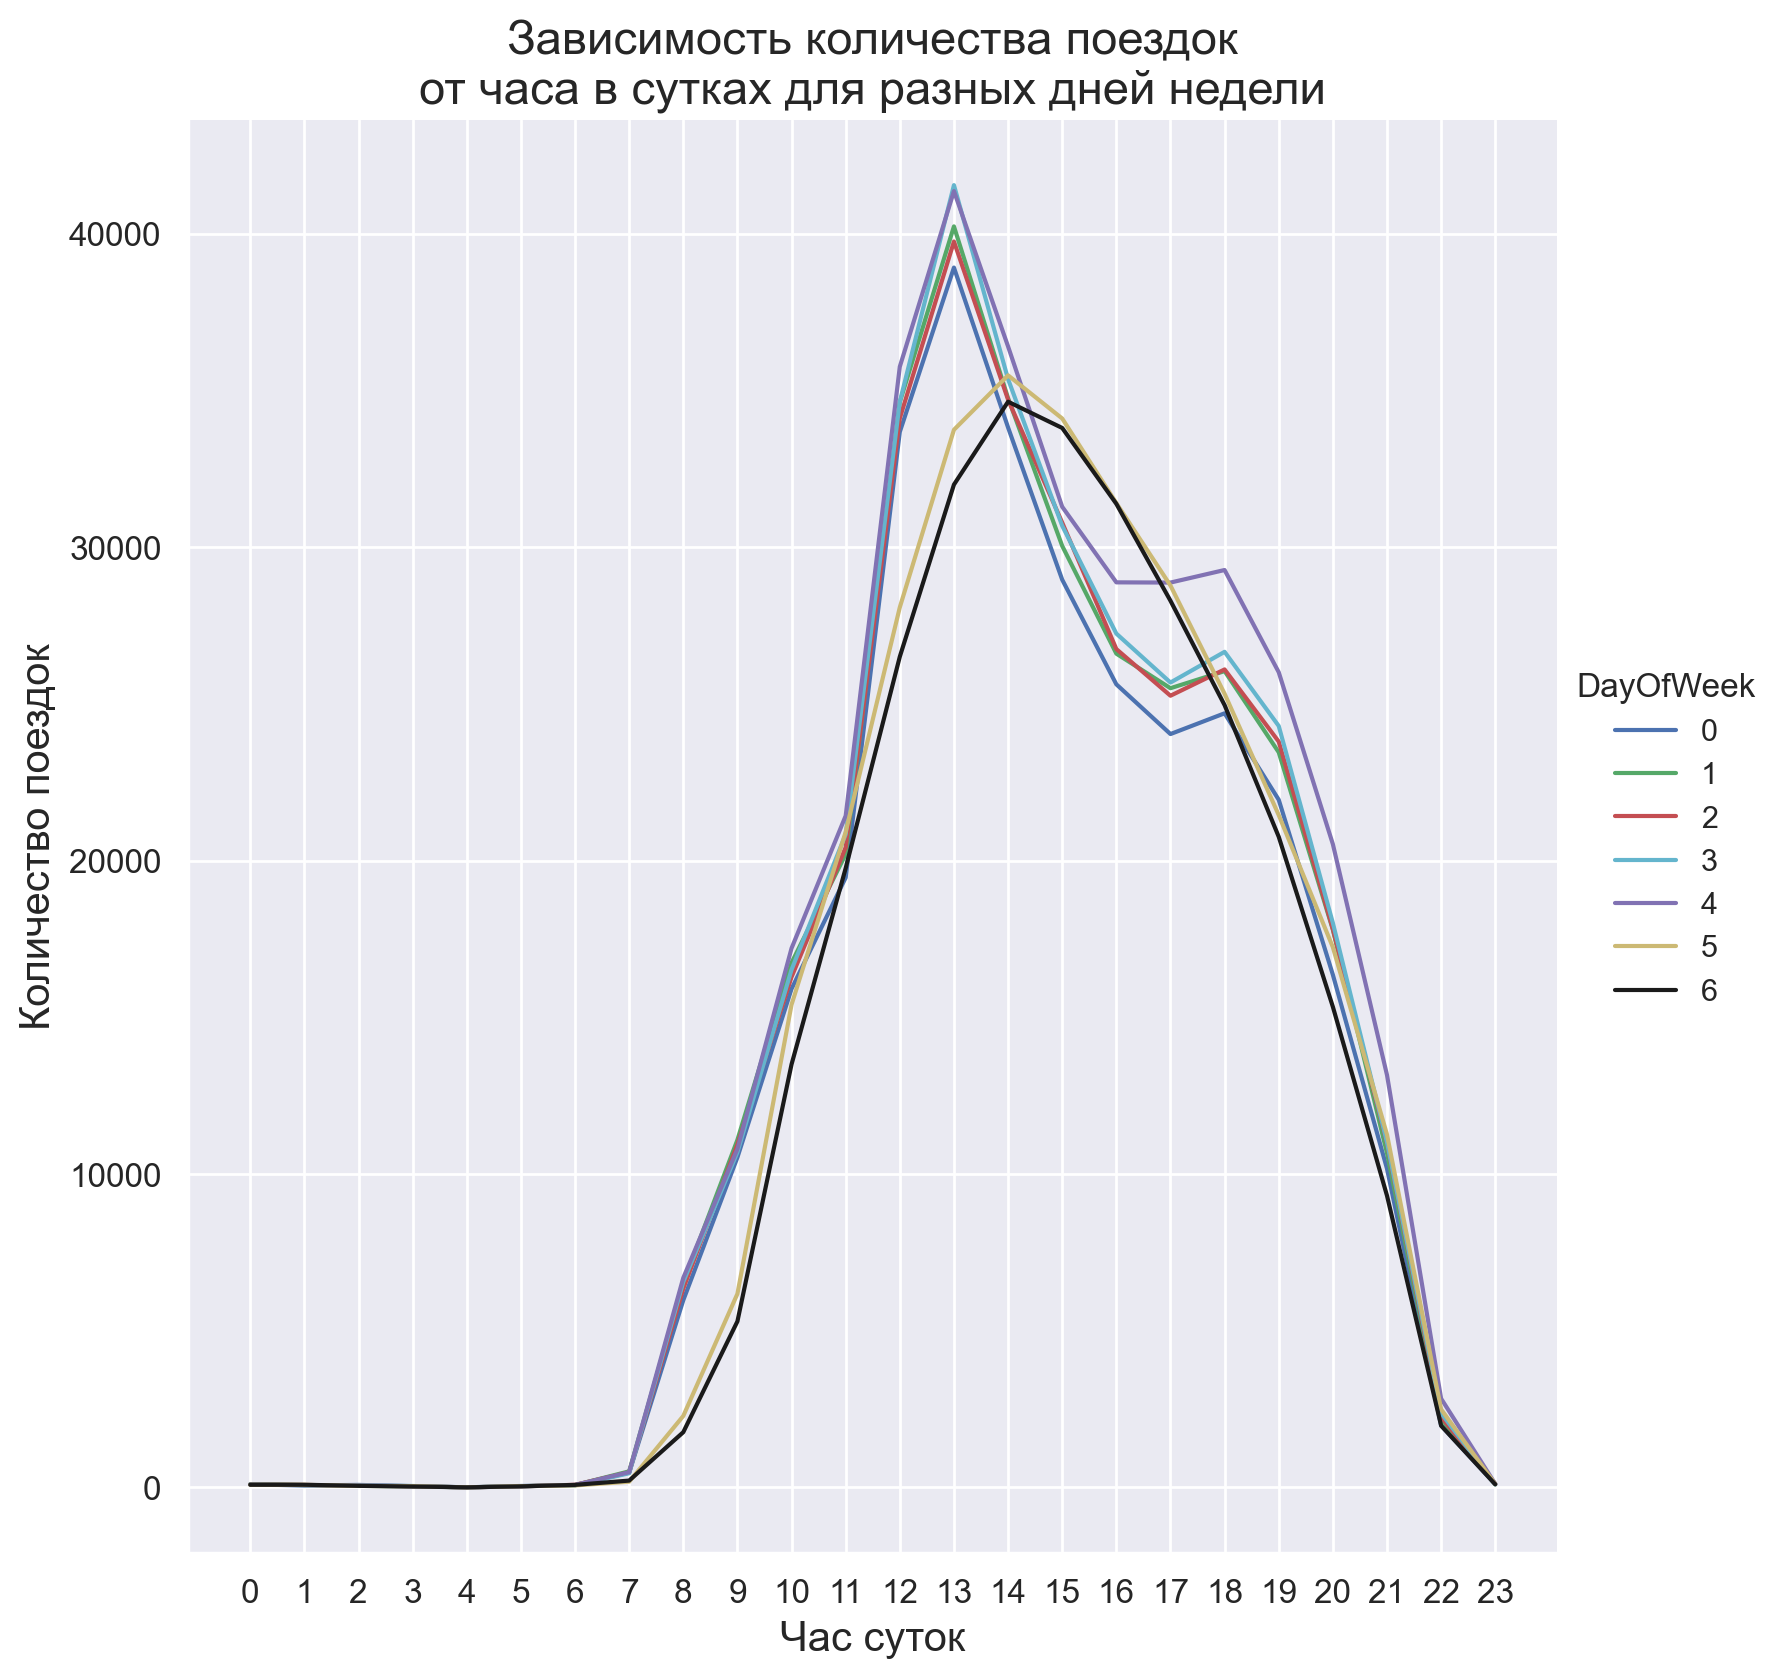

In [21]:
sns.relplot(df.groupby(['Hour', 'DayOfWeek']).UID.count().to_frame(), 
                              x = 'Hour', 
                              y = 'UID', 
                              kind='line',
                              palette=['b', 'g', 'r', 'c', 'm', 'y', 'k'],
                              height = 8, 
                              hue='DayOfWeek')
plt.title('Зависимость количества поездок\nот часа в сутках для разных дней недели', fontsize=17)
plt.xlabel('Час суток', fontsize=15)
plt.ylabel('Количество поездок', fontsize=15)
plt.xticks(np.arange(24), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Формирование датасета с клиентами

Начинаем собирать данные по клиентам. Начинаем с последнего статуса, далее оценим покупательскую активность по RFM-анализу

In [23]:
clients = df.groupby('UID').Status.last().to_frame()

### Recency

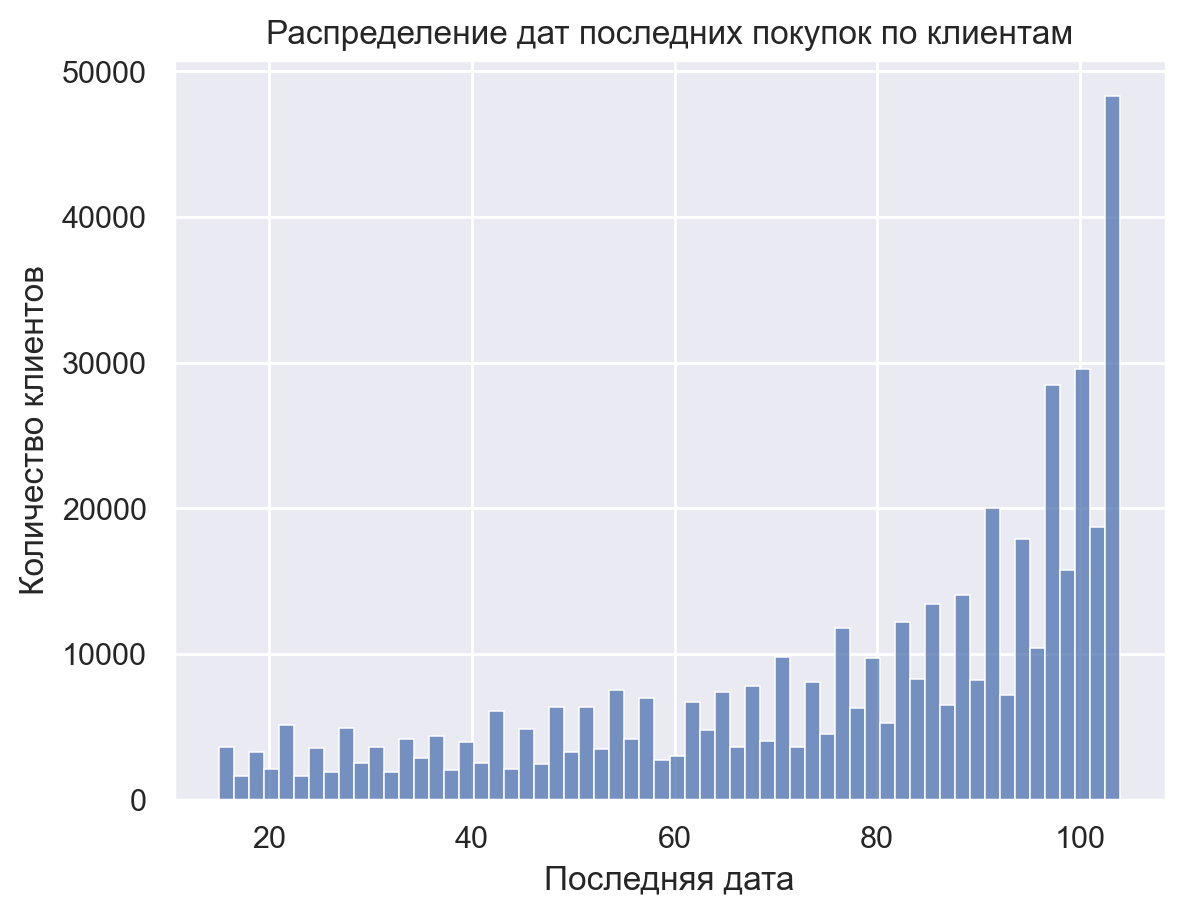

In [24]:
sns.histplot(df.groupby('UID').DayOfYear.max(), bins=60)
plt.title('Распределение дат последних покупок по клиентам')
plt.xlabel('Последняя дата')
plt.ylabel('Количество клиентов')
plt.show()

Пока в качестве Recency берём последний день в году, когда совершалась покупка. Чем больше recency, тем клиент лучше

## Frequency 
(рассматривать разные периоды)

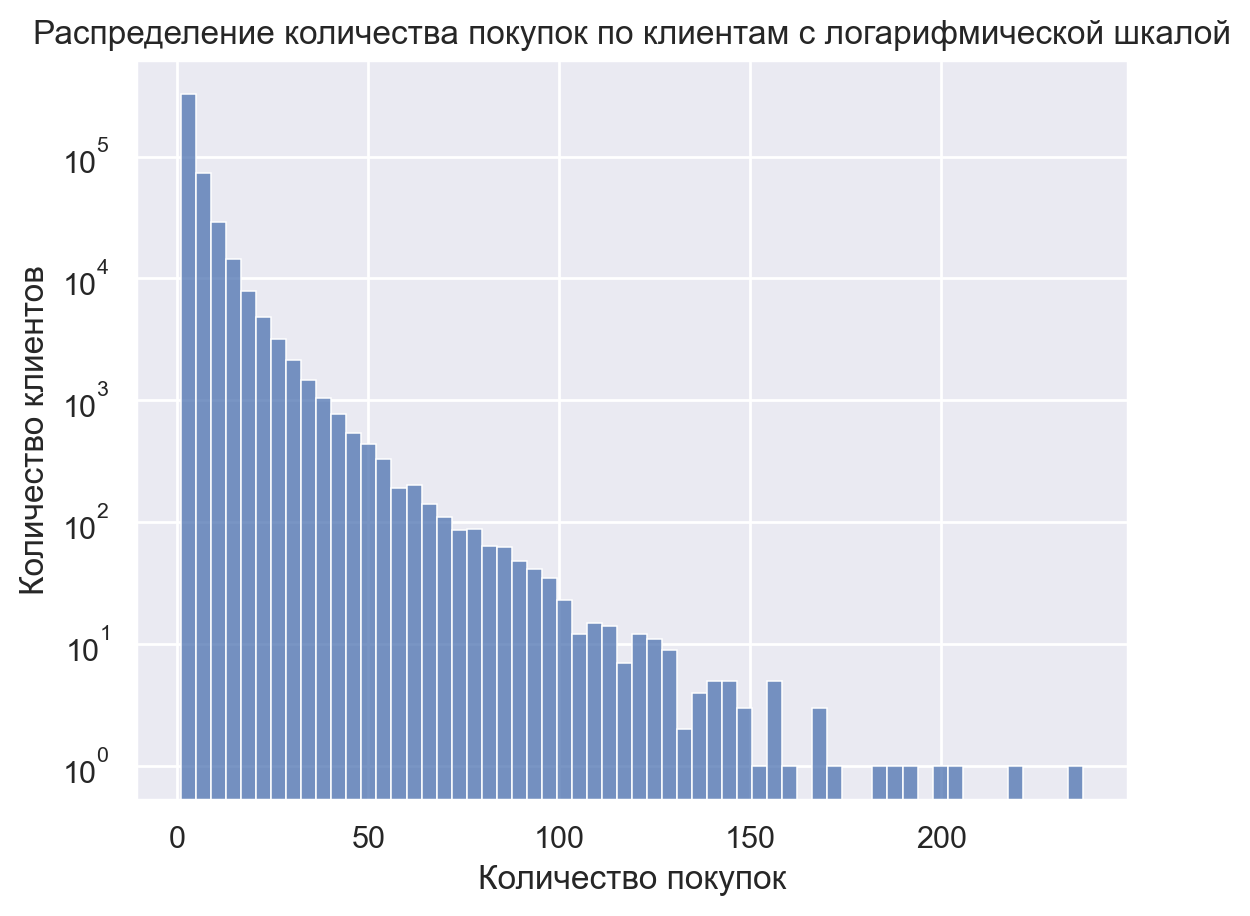

In [26]:
sns.histplot(df.groupby('UID').Price.count(), bins=60)
plt.title('Распределение количества покупок по клиентам с логарифмической шкалой')
plt.xlabel('Количество покупок')
plt.ylabel('Количество клиентов')
plt.yscale('log')
plt.show()

Любимый день недели по средним тратам

In [28]:
clients['FavouriteDay'] = df.groupby(['UID', 'DayOfWeek']).Price.mean().to_frame().reset_index().sort_values(by = ['UID', 'Price'], ascending=False).groupby('UID').DayOfWeek.first()

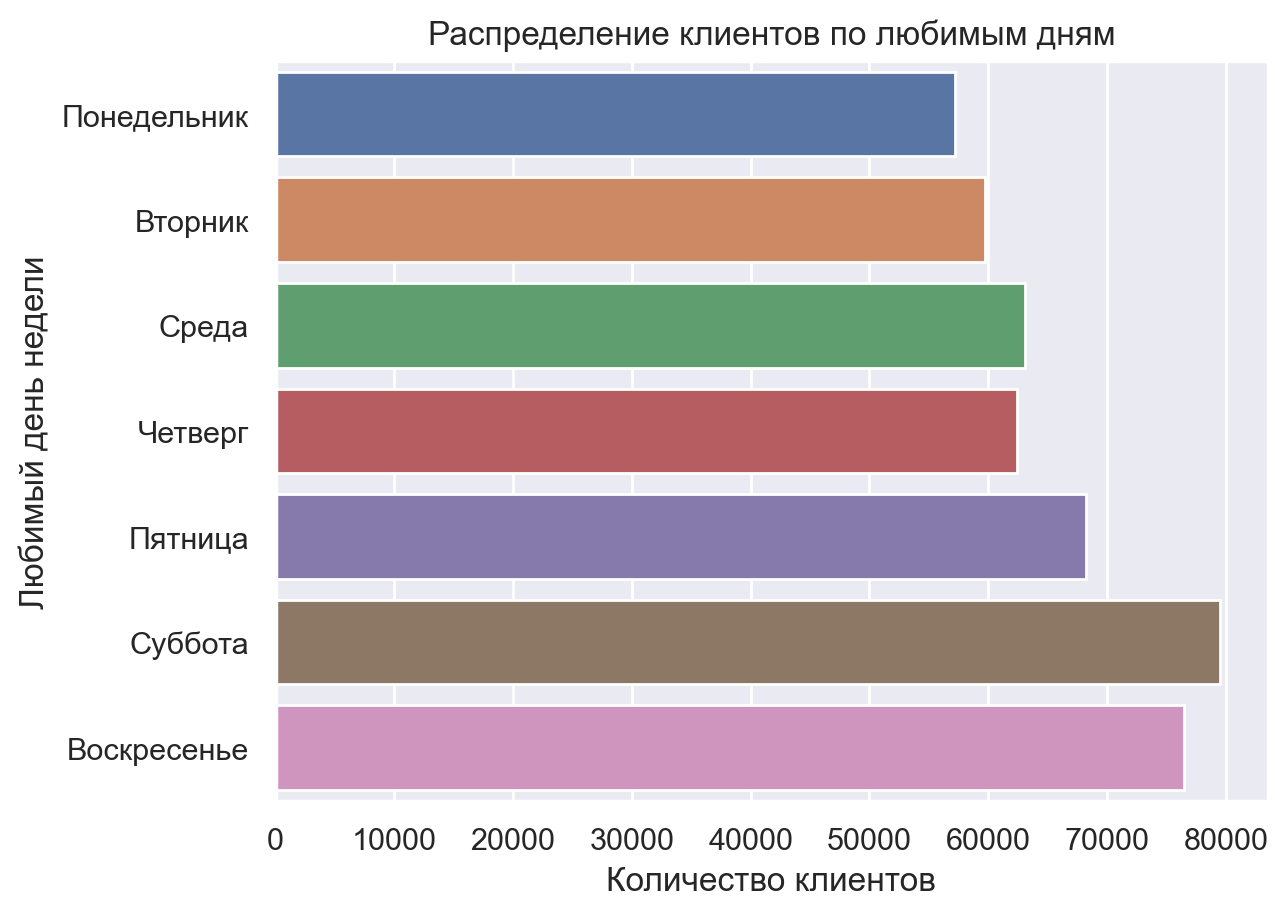

In [29]:
sns.countplot(order=range(7), y='FavouriteDay', data=clients)
plt.title('Распределение клиентов по любимым дням')
plt.xlabel("Количество клиентов")
plt.ylabel("Любимый день недели")
plt.yticks(range(7), labels=day_of_week_labels)
plt.show()

## Monetary

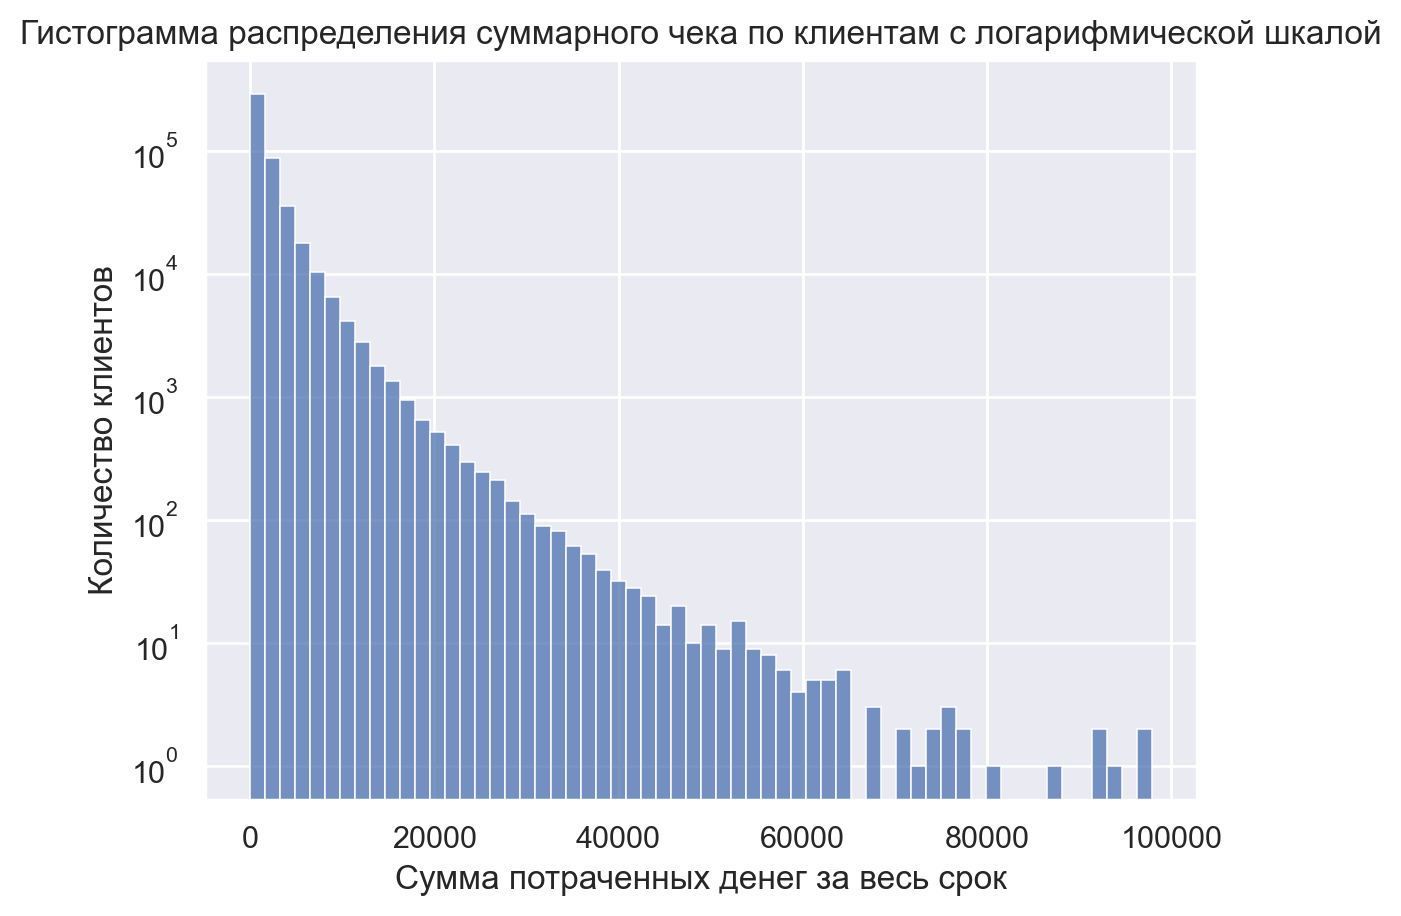

In [30]:
sns.histplot(df.groupby('UID').Price.sum(), bins=60)
plt.title('Гистограмма распределения суммарного чека по клиентам с логарифмической шкалой')
plt.xlabel('Сумма потраченных денег за весь срок')
plt.ylabel('Количество клиентов')
plt.yscale('log')
plt.show()

Для monetary попробуем две метрики - средний чек и сумма всех покупок

## Формирование воздействий на клиентов и целевой переменной

### Воздействие $T_1$ - Переход на новый статус лояльности

В последствии в нашем датасете клиентов мы будем называть его TreatmentStatus

In [32]:
hierarchy = {"Бронзовый ключ": 0, "Серебряный ключ": 1, "Золотой ключ": 2, "Платиновый ключ": 3, "Сотрудник": 4}
df['StatusNew'] = df["Status"].apply(lambda x: hierarchy[x])

In [33]:
middle_data = df.loc['2023-02-15':'2023-03-15'].groupby('UID').StatusNew
clients['TreatmentStatus'] = (middle_data.is_monotonic_increasing) & (middle_data.nunique() > 1)

In [34]:
clients['TreatmentStatus'].fillna(value = False, inplace = True)
clients['TreatmentStatus'] = clients['TreatmentStatus'].astype(int)
clients

,Status,Recency,Frequency,FavouriteDay,Monetary_Sum,Monetary_Mean,TreatmentStatus
UID,,,,,,,
00004b3d-550c-11ec-80da-00155dd23e20,Бронзовый ключ,98,2,5,715.00,357.500000,0
0000582d-3d6f-11ed-80df-00155dd23e20,Платиновый ключ,83,13,6,6661.00,512.384615,0
000058d5-6d87-11ed-80e2-00155dd23e20,Платиновый ключ,100,5,4,3225.00,645.000000,0
00005d8b-08e4-11ed-80dd-00155dd23e20,Бронзовый ключ,50,3,4,2306.00,768.666667,0
0000bc9f-3799-11ea-80d4-f403433ddaaf,Серебряный ключ,101,4,1,1745.00,436.250000,0
...,...,...,...,...,...,...,...
ffff9419-16cf-11ec-80d8-00155dd23e20,Серебряный ключ,41,1,4,1601.00,1601.000000,0
ffffa515-53b1-11ed-80e0-00155dd23e20,Бронзовый ключ,53,4,2,763.00,190.750000,0
ffffac76-619a-11ed-80e1-00155dd23e20,Серебряный ключ,26,4,6,2803.00,700.750000,0


Проверяю, что это вообще работает

In [36]:
df[df['UID'] == '0019e1b8-f6e0-11ec-80dd-00155dd23e20']

,UID,OperationType,Price,SpentCoins,GainedCoins,Point,Agent,Status,Discount,DayOfWeek,Month,Hour,DayOfYear,StatusNew
Date,,,,,,,,,,,,,,
2023-01-28 17:37:40,0019e1b8-f6e0-11ec-80dd-00155dd23e20,Покупка,691.0,0.0,13.82,Р Город Лефортово,Касса,Бронзовый ключ,0.02,5,1,17,28,0
2023-01-29 13:31:35,0019e1b8-f6e0-11ec-80dd-00155dd23e20,Покупка,889.0,0.0,26.67,Р Павелецкая Плаза,Касса,Серебряный ключ,0.03,6,1,13,29,1
2023-02-14 15:00:32,0019e1b8-f6e0-11ec-80dd-00155dd23e20,Покупка,453.0,0.0,13.59,Р Никольская,Касса,Серебряный ключ,0.03,1,2,15,45,1
2023-02-14 15:01:54,0019e1b8-f6e0-11ec-80dd-00155dd23e20,Покупка,325.0,0.0,9.75,Р Никольская,Касса,Серебряный ключ,0.03,1,2,15,45,1
2023-02-14 15:04:08,0019e1b8-f6e0-11ec-80dd-00155dd23e20,Покупка,1.0,214.0,0.03,Р Никольская,Касса,Серебряный ключ,0.03,1,2,15,45,1
2023-03-11 18:02:40,0019e1b8-f6e0-11ec-80dd-00155dd23e20,Покупка,1385.0,0.0,41.55,Р Авиа Парк,Касса,Серебряный ключ,0.03,5,3,18,70,1
2023-03-12 15:24:52,0019e1b8-f6e0-11ec-80dd-00155dd23e20,Покупка,227.0,0.0,11.35,Р Город Лефортово,Касса,Золотой ключ,0.05,6,3,15,71,2


### Воздействие $T_2$ - Использование баллов Спасибо

**Рассуждения**

$round((price - sber) * discount, 2) = gained\_coins$

По правилам округления до сотых делаем оценку

$(price - sber) * discount = gained\_coins \pm 0.005$

$price - sber = \frac{gained\_coins \pm 0.005}{discount}$

$sber = price - \frac{gained\_coins \pm 0.005}{discount}$

$sber = price - \frac{gained\_coins}{discount} \pm \frac{0.005}{discount}$

Оцениваем $\frac{0.005}{discount}$ по максимально возможному значению скидки $0.02: \frac{0.005}{0.02} = 0.25$

Значит, во всех транзакциях, где полученный $sber$ больше 0.25 мы имели дело с реальным использованием баллов Спасибо

**Вывод**

Для надёжности и логичности введём порог на воздействие с помощью баллов Спасибо в размере 10 рублей

In [37]:
df['SberSpasibo'] = 0
df.loc[df.Price - df.GainedCoins / df.Discount > 10, 'SberSpasibo'] = 1
clients['SberSpasibo'] = df.groupby('UID').SberSpasibo.any()

In [38]:
df[(df['SberSpasibo'] > 0) & (df['Agent'] != 'Касса') & (df['OperationType'] != 'Возврат')]

,UID,OperationType,Price,SpentCoins,GainedCoins,Point,Agent,Status,Discount,DayOfWeek,Month,Hour,DayOfYear,StatusNew,SberSpasibo
Date,,,,,,,,,,,,,,,
2023-01-15 11:13:29,e7617eb3-ee56-11ec-80dd-00155dd23e20,Покупка,687.0,0.0,0.00,Р Форт Отрадное,Мобильное приложение,Бронзовый ключ,0.02,6,1,11,15,0,1
2023-01-15 11:17:21,0957330a-64c9-11ed-80e1-00155dd23e20,Покупка,690.0,0.0,7.88,Р Ашан Гагаринский,Мобильное приложение,Бронзовый ключ,0.02,6,1,11,15,0,1
2023-01-15 11:47:32,4e3b02fa-2ef0-11ea-80d4-f403435823a3,Покупка,671.0,0.0,22.40,Р Колумбус Южная Галерея,Мобильное приложение,Платиновый ключ,0.07,6,1,11,15,3,1
2023-01-15 12:11:06,80369a97-94b2-11ed-80e3-00155dd23e20,Покупка,86.0,0.0,0.00,Р XL Мытищи,Мобильное приложение,Бронзовый ключ,0.02,6,1,12,15,0,1
2023-01-15 12:23:17,ee218de3-4d0d-11eb-80e6-f403435823a3,Покупка,764.0,0.0,24.20,Р Новогиреево,Мобильное приложение,Золотой ключ,0.05,6,1,12,15,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-14 20:39:37,f876c82a-27fe-11eb-80e5-f403435823a3,Покупка,240.0,0.0,0.00,Р Конфитюр Железнодорожный,Мобильное приложение,Золотой ключ,0.05,4,4,20,104,2,1
2023-04-14 20:40:27,9e4bf418-98d7-11ed-80e3-00155dd23e20,Покупка,806.0,0.0,5.80,Р Фестиваль СТР,Мобильное приложение,Бронзовый ключ,0.02,4,4,20,104,0,1
2023-04-14 20:51:27,9b30e7e7-933c-11ed-80e3-00155dd23e20,Покупка,322.0,0.0,0.00,Р Колумбус Южная Галерея,Мобильное приложение,Серебряный ключ,0.03,4,4,20,104,1,1


## Целевая переменная Y(Эксперимент с causes and outcomes)

### Запускать только в случае если это нужно

In [41]:
clients['Recency'] = df.loc[:'2023-02-15'].groupby('UID').DayOfYear.max()
clients['Frequency'] = df.loc[:'2023-02-15'].groupby('UID').Price.count()
clients['Monetary_Sum'] = df.loc[:'2023-02-15'].groupby('UID').Price.sum()
clients['Monetary_Mean'] = df.loc[:'2023-02-15'].groupby('UID').Price.mean()


In [42]:
clients['outcome'] = df.loc['2023-03-15':].groupby('UID').Price.sum()
clients['outcome'].fillna(0, inplace=True)
clients.dropna(inplace=True)
print(clients.shape)

(400717, 13)
